In [ ]:
%wget https://datasets.imdbws.com/title.basics.tsv.gz
%wget https://datasets.imdbws.com/title.ratings.tsv.gz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import xticks

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [4]:
title = "The Godfather"

# Read the title.basics.tsv.gz and title.ratings.tsv.gz datasets into Pandas DataFrames
basics_data = pd.read_csv("title.basics.tsv.gz", sep="\t")
ratings_data = pd.read_csv("title.ratings.tsv.gz", sep="\t")

# Merge the two datasets on the tconst column
data = pd.merge(basics_data, ratings_data, on="tconst")

# Filter the data to only include movies
data = data[data['titleType'] == 'movie']

# Print first 100 head
data.head(100)

# Select the columns that we want to use to train the model
data = data[["primaryTitle", "genres", "startYear", "averageRating"]]

# Replace \N values with NaN
data.replace("\\N", np.nan, inplace=True)

# Remove any rows with missing or incomplete data
data.dropna(inplace=True)

# Convert the start year column to an integer
data["startYear"] = data["startYear"].astype(int)

/Users/efecan/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


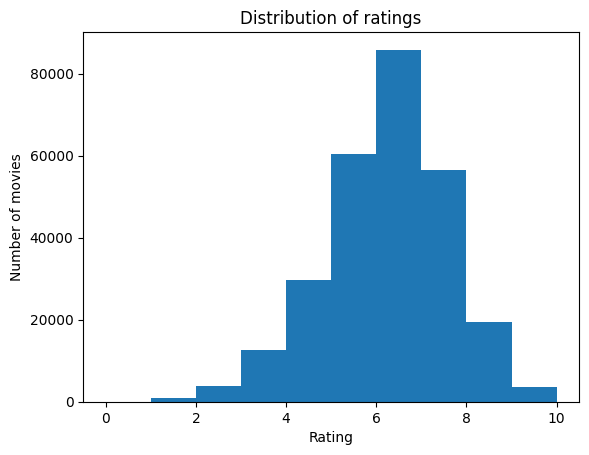

In [5]:
y = data["averageRating"]
y = y.dropna() # remove rows with missing values
y = y.values

# Create the histogram
fig, ax = plt.subplots()
ax.hist(y, bins=10, range=(0, 10))
ax.set_xlabel("Rating")
ax.set_ylabel("Number of movies")
ax.set_title("Distribution of ratings")
plt.show()

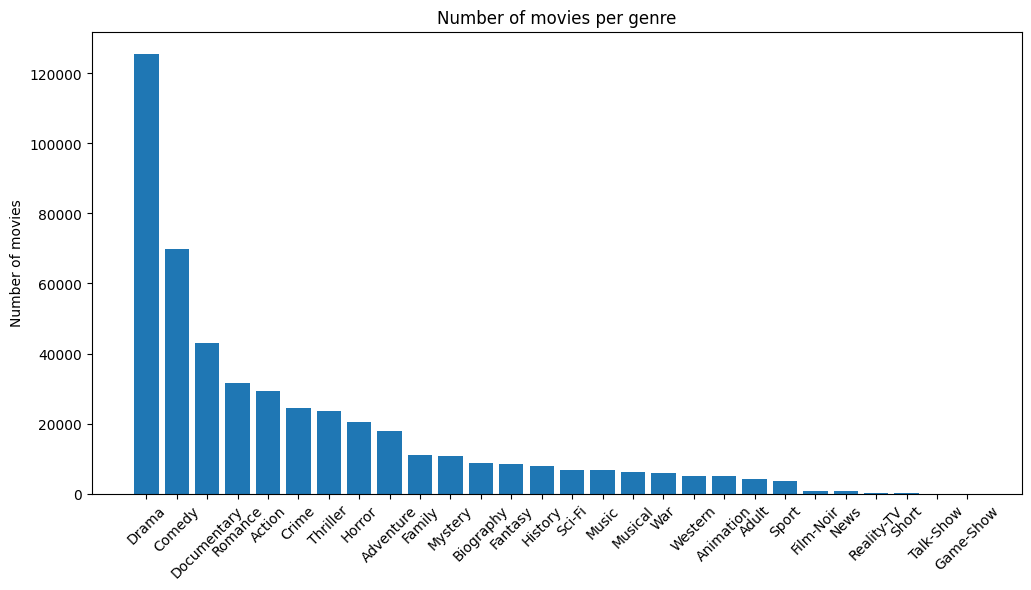

In [6]:
# Compute the number of movies in each genre
genre_counts = data["genres"].str.split(",").explode().value_counts()

# Create the bar chart with a larger figure
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(genre_counts.size), genre_counts.values)
ax.set_xticks(range(genre_counts.size))
ax.set_xticklabels(genre_counts.index, rotation=45)
ax.set_ylabel("Number of movies")
ax.set_title("Number of movies per genre")
plt.show()

In [7]:
# Convert the genres column to a numerical representation using one-hot encoding
transformer = ColumnTransformer(transformers=[("onehot", OneHotEncoder(), ["genres"])])
tdata = pd.DataFrame(transformer.fit_transform(data).toarray())

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tdata, data["averageRating"], test_size=0.2, random_state=42)

In [8]:
# Create a LinearRegression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

LinearRegression()

In [9]:
from sklearn.metrics import mean_squared_error

# Evaluate the model on the test set
y_pred = model.predict(X_test)
test_loss = mean_squared_error(y_test, y_pred)
print(f"Test loss: {test_loss}")

Test loss: 1.6270151616553425e+20


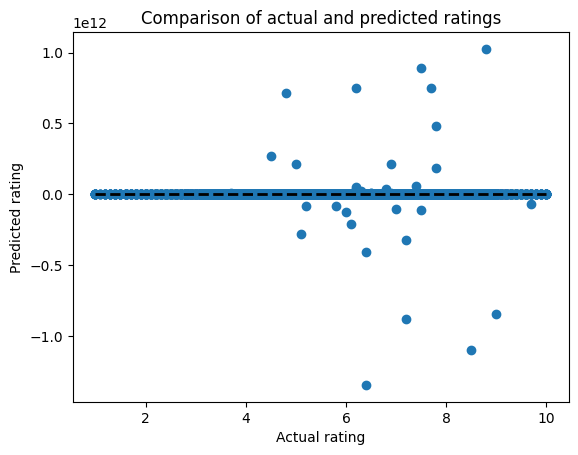

In [10]:
# Create the scatterplot
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel("Actual rating")
ax.set_ylabel("Predicted rating")
ax.set_title("Comparison of actual and predicted ratings")
plt.show()

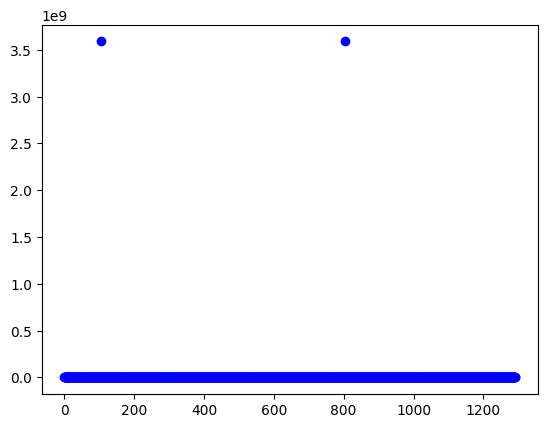

In [11]:
# Use the model to predict the ratings for the test data
y_pred = model.predict(X_test)

# Zip the input features and predicted ratings into tuples
xy_pairs = zip(X_test, y_pred)

# Iterate over the tuples and create a scatter plot of the predicted ratings
for x, y in xy_pairs:
    plt.scatter(x, y, color="blue")

# Show the plot
plt.show()

In [27]:
def recommend_movies(title):
	# Use the model to predict the ratings of movies with the given title
	movie_data = data[data["primaryTitle"] == title][["primaryTitle", "genres", "startYear", "averageRating"]]
	movie_data["startYear"] = movie_data["startYear"].astype(int)
	tmovie_data = pd.DataFrame(transformer.transform(movie_data).toarray())
	predicted_rating = model.predict(tmovie_data)[0] 
	print("Predicted Movie Rating: " + str(predicted_rating))

	# Recommend similar movies with the best ratings
	recommended_movies = data[data["genres"] == movie_data["genres"].iloc[0]].sort_values("averageRating", ascending=False)
	recommended_movies = recommended_movies.head(10)

	plt.figure(figsize=(8, 4))
	plt.bar(recommended_movies["primaryTitle"], recommended_movies["averageRating"], color="blue")
	plt.xlabel("Movie title")
	plt.ylabel("Rating")
	plt.title("Recommended movies for " + title)

	# Set the rotation and font size of the tick labels
	xticks(rotation=45, fontsize=12)

	# Show the plot
	plt.show()

	return recommended_movies

Predicted Movie Rating: 6.118585586547852


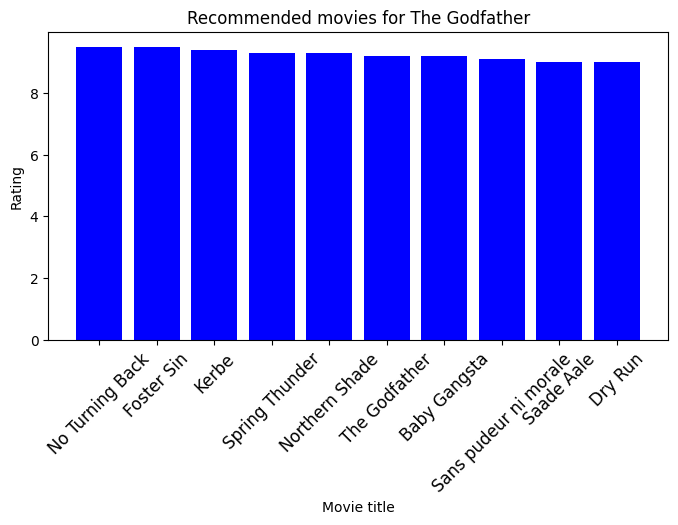

,primaryTitle,genres,startYear,averageRating
800335,No Turning Back,"Crime,Drama",2022,9.5
1200605,Foster Sin,"Crime,Drama",2018,9.5
834730,Kerbe,"Crime,Drama",2021,9.4
1199739,Spring Thunder,"Crime,Drama",2018,9.3
614818,Northern Shade,"Crime,Drama",2022,9.3
45807,The Godfather,"Crime,Drama",1972,9.2
1217095,Baby Gangsta,"Crime,Drama",2020,9.2
827478,Sans pudeur ni morale,"Crime,Drama",2011,9.1
1190101,Saade Aale,"Crime,Drama",2022,9.0
552072,Dry Run,"Crime,Drama",2010,9.0


In [28]:
recommend_movies("The Godfather")

Predicted Movie Rating: 4.9241623878479


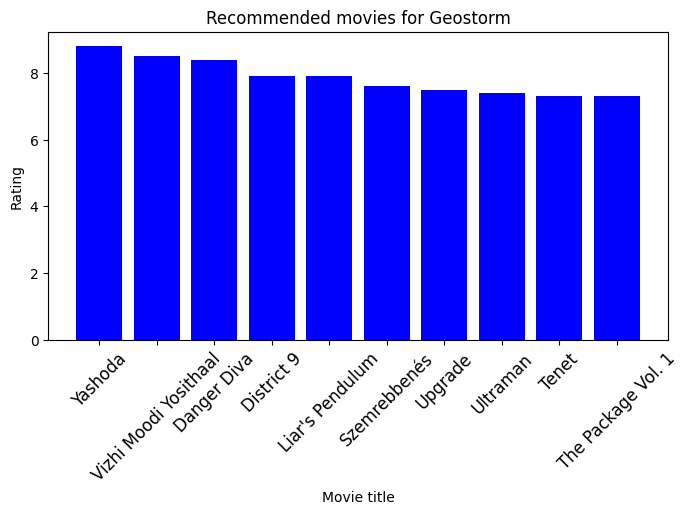

,primaryTitle,genres,startYear,averageRating
703362,Yashoda,"Action,Sci-Fi,Thriller",2022,8.8
1182289,Vizhi Moodi Yosithaal,"Action,Sci-Fi,Thriller",2014,8.5
1018228,Danger Diva,"Action,Sci-Fi,Thriller",2020,8.4
513682,District 9,"Action,Sci-Fi,Thriller",2009,7.9
475384,Liar's Pendulum,"Action,Sci-Fi,Thriller",2007,7.9
1035150,Szemrebbenés,"Action,Sci-Fi,Thriller",2015,7.6
1112951,Upgrade,"Action,Sci-Fi,Thriller",2018,7.5
132307,Ultraman,"Action,Sci-Fi,Thriller",1967,7.4
1122790,Tenet,"Action,Sci-Fi,Thriller",2020,7.3
743956,The Package Vol. 1,"Action,Sci-Fi,Thriller",2010,7.3


In [29]:
recommend_movies("Geostorm")

Predicted Movie Rating: 6.118585586547852


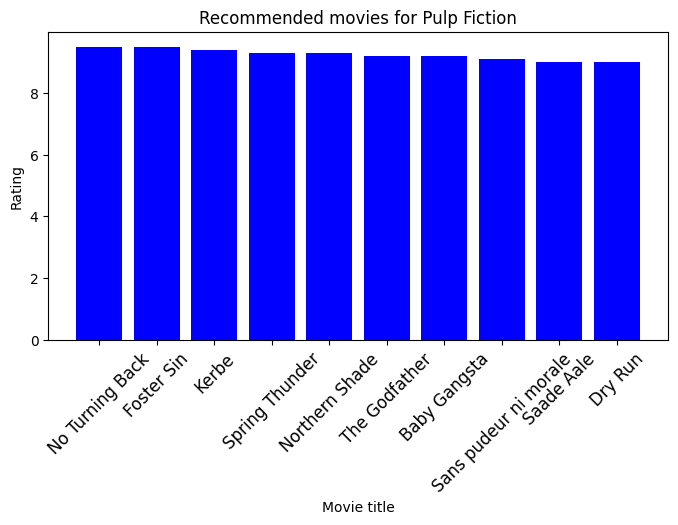

,primaryTitle,genres,startYear,averageRating
800335,No Turning Back,"Crime,Drama",2022,9.5
1200605,Foster Sin,"Crime,Drama",2018,9.5
834730,Kerbe,"Crime,Drama",2021,9.4
1199739,Spring Thunder,"Crime,Drama",2018,9.3
614818,Northern Shade,"Crime,Drama",2022,9.3
45807,The Godfather,"Crime,Drama",1972,9.2
1217095,Baby Gangsta,"Crime,Drama",2020,9.2
827478,Sans pudeur ni morale,"Crime,Drama",2011,9.1
1190101,Saade Aale,"Crime,Drama",2022,9.0
552072,Dry Run,"Crime,Drama",2010,9.0


In [30]:
recommend_movies("Pulp Fiction")

Predicted Movie Rating: 6.118585586547852


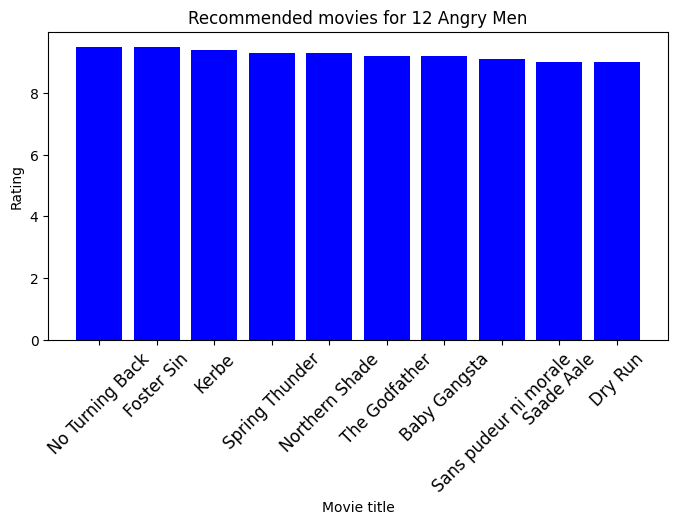

,primaryTitle,genres,startYear,averageRating
800335,No Turning Back,"Crime,Drama",2022,9.5
1200605,Foster Sin,"Crime,Drama",2018,9.5
834730,Kerbe,"Crime,Drama",2021,9.4
1199739,Spring Thunder,"Crime,Drama",2018,9.3
614818,Northern Shade,"Crime,Drama",2022,9.3
45807,The Godfather,"Crime,Drama",1972,9.2
1217095,Baby Gangsta,"Crime,Drama",2020,9.2
827478,Sans pudeur ni morale,"Crime,Drama",2011,9.1
1190101,Saade Aale,"Crime,Drama",2022,9.0
552072,Dry Run,"Crime,Drama",2010,9.0


In [31]:
recommend_movies("12 Angry Men")

Predicted Movie Rating: 4.7063093185424805


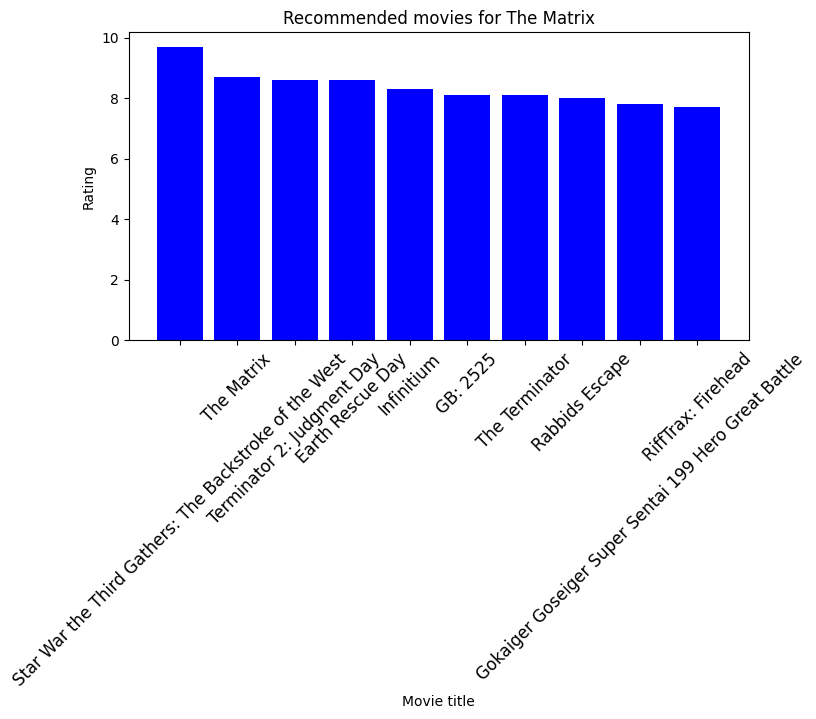

,primaryTitle,genres,startYear,averageRating
761730,Star War the Third Gathers: The Backstroke of ...,"Action,Sci-Fi",2010,9.7
96322,The Matrix,"Action,Sci-Fi",1999,8.7
75356,Terminator 2: Judgment Day,"Action,Sci-Fi",1991,8.6
813617,Earth Rescue Day,"Action,Sci-Fi",2021,8.6
1026253,Infinitium,"Action,Sci-Fi",2017,8.3
240164,GB: 2525,"Action,Sci-Fi",2009,8.1
62672,The Terminator,"Action,Sci-Fi",1984,8.1
698993,Rabbids Escape,"Action,Sci-Fi",2021,8.0
773860,Gokaiger Goseiger Super Sentai 199 Hero Great ...,"Action,Sci-Fi",2011,7.8
679320,RiffTrax: Firehead,"Action,Sci-Fi",2013,7.7


In [32]:
recommend_movies("The Matrix")

# References

Linear Regression Model for Training and Prediction - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
Preparing training data for model - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Converting dataset to vectors for training - https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

Graphing - https://matplotlib.org/stable/plot_types/index.html
Graphing - https://matplotlib.org/stable/plot_types/basic/bar.html#sphx-glr-plot-types-basic-bar-py
Graphing - https://matplotlib.org/stable/plot_types/basic/scatter_plot.html#sphx-glr-plot-types-basic-scatter-plot-py

Reading TSV Dataset: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
Manipulating IMDB dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
